# irradiance.py tutorial

This tutorial explores some of the functions available in the ``pvlib`` module ``irradiance.py``.

This tutorial is known to work with the following package versions:
* pvlib 0.2.0
* Python 2.7.10
* IPython 3.2
* pandas 0.16.2

It should work with other Python and Pandas versions. It requires pvlib >= 0.2.0 and IPython >= 3.0.

Authors:
* Will Holmgren (@wholmgren), University of Arizona. July 2014, April 2015, July 2015.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set(rc={'figure.figsize':(12,6)})
except ImportError:
    pass
    
# built in python modules
import datetime

# python add-ons
import numpy as np
import pandas as pd

import pvlib

## Table of contents

1. [Extraterrestrial radiation](#Extraterrestrial-radiation)
2. [Clear sky models](#Clear-sky-models)
2. [Diffuse ground](#Diffuse-ground)
2. [Diffuse sky](#Diffuse-sky)
    1. [Isotropic](#Isotropic-model)
    2. [Klucher](#Klucher-model)
    2. [Reindl](#Reindl-model)
    2. [Hay-Davies](#Hay-Davies-model)
    2. [Perez](#Perez-model)
2. [Angle of incidence](#Angle-of-incidence-functions)
2. [total_irrad](#total_irrad)

### Extraterrestrial radiation

Many solar power algorithms start with the irradiance incident on the top of the Earth's atmosphere, often known as the extraterrestrial radiation. ``pvlib`` has three different algorithms to calculate the yearly cycle of the extraterrestrial radiation given the solar constant.

In [2]:
times = pd.date_range('2014-01-01', '2015-01-01', freq='1D')

In [3]:
spencer = pd.Series(pvlib.irradiance.extraradiation(times, method='spencer'), times)
asce = pd.Series(pvlib.irradiance.extraradiation(times, method='asce'), times)
ephem = pvlib.irradiance.extraradiation(times, method='pyephem') # approx 100x slower than the above.

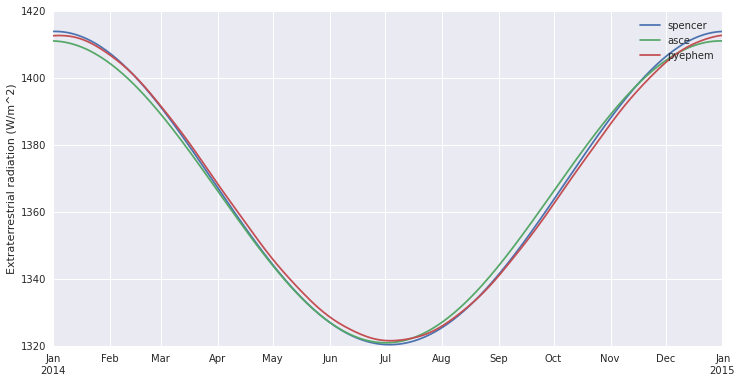

In [4]:
spencer.plot(label='spencer')
asce.plot(label='asce')
ephem.plot(label='pyephem')
plt.legend()
plt.ylabel('Extraterrestrial radiation (W/m^2)')

The ``pyephem`` method is probably the most accurate since it uses an external library specifically designed for astronomical position calculations. However, as shown in the plot below, the difference is only +/-2 W/m^2 over the entire year.

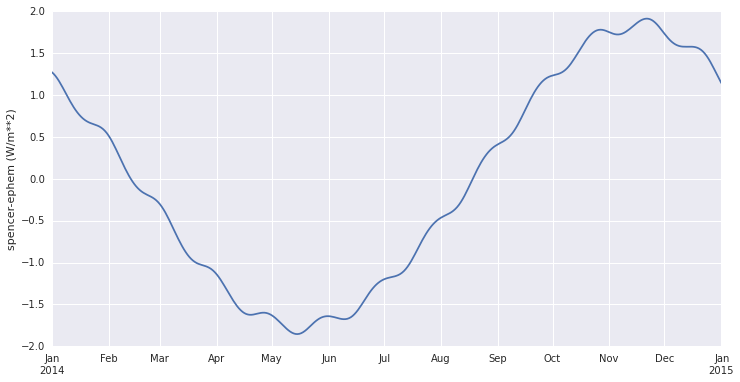

In [5]:
et_diff = spencer - ephem
et_diff.plot()
plt.ylabel('spencer-ephem (W/m**2)')

You can also control the solar constant.

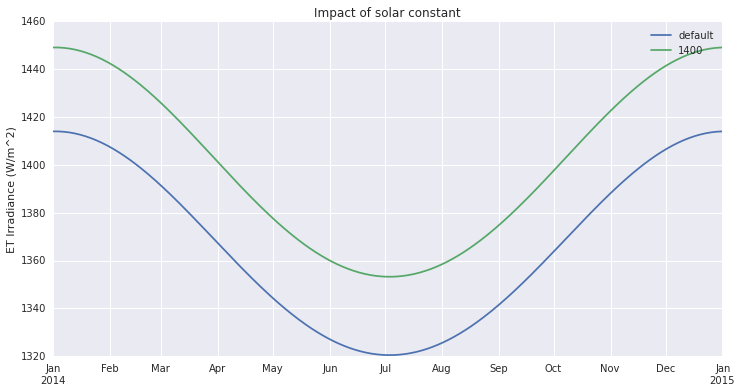

In [6]:
spencer_1400 = pd.Series(pvlib.irradiance.extraradiation(times, method='spencer', solar_constant=1400), times)

spencer.plot(label='default')
spencer_1400.plot(label='1400')
plt.legend()
plt.title('Impact of solar constant')
plt.ylabel('ET Irradiance (W/m^2)')

## Clear sky models

``pvlib`` has two different clear sky models: Ineichen and Haurwitz. We'll explore some of the features of each of them.

First, we need to make a ``Location`` object so that ``pvlib`` can calculate the solar position when needed.

In [7]:
from pvlib.location import Location

tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')
print(tus)

Tucson: latitude=32.2, longitude=-111, tz=US/Arizona, altitude=700


In [8]:
times = pd.date_range(start=datetime.datetime(2014,1,1), end=datetime.datetime(2014,1,2), freq='1Min').tz_localize(tus.tz)
solpos = pvlib.solarposition.get_solarposition(times, tus, method='pyephem')
ephem_data = solpos

#### Haurwitz

The Haurwitz model is a very simple model that only needs the solar zenith.

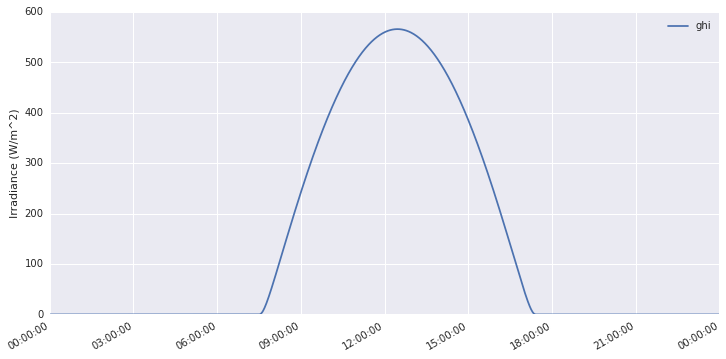

In [9]:
irrad_data = pvlib.clearsky.haurwitz(solpos['apparent_zenith'])
irrad_data.plot()
plt.ylabel('Irradiance (W/m^2)')

#### Ineichen

The ``ineichen`` algorithm only requires you to supply the times and the location, but accepts many more optional parameters. It automatically calculates the solar position and looks up the Linke turbidity (related to the optical depth of the atmosphere).

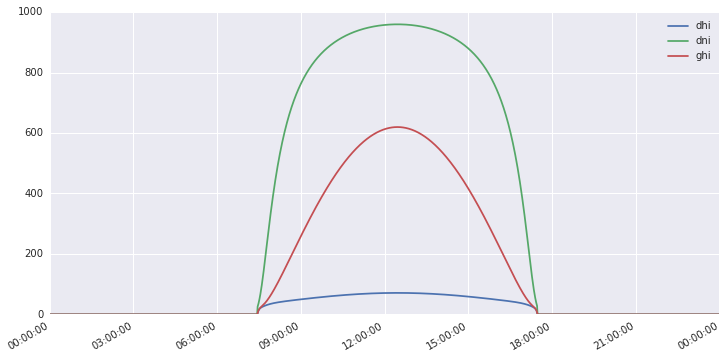

In [10]:
irrad_data = pvlib.clearsky.ineichen(times, tus)
irrad_data.plot()

The Linke turbidity lookup table uses monthly values, but these are interpolated down to daily values by default. You can also specify the value yourself. You can also supply the zenith angle to avoid recalculating the solar position each time the function is called.

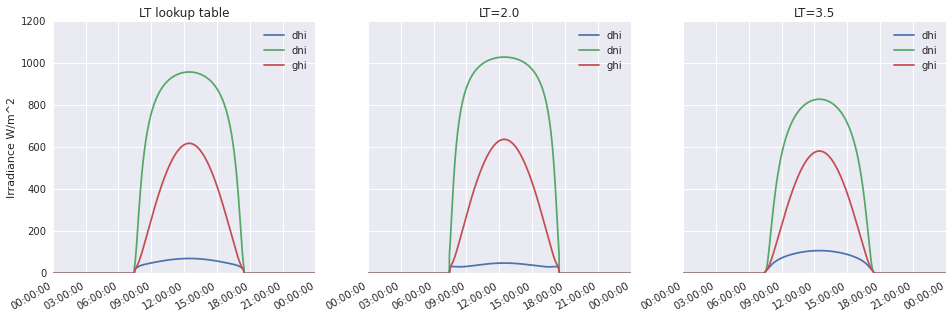

In [11]:
solpos = pvlib.solarposition.get_solarposition(times, tus, method='pyephem')

fig, axes = plt.subplots(1,3, figsize=(16,5), sharey=True)

irrad_data = pvlib.clearsky.ineichen(times, tus, linke_turbidity=None, zenith_data=solpos['apparent_zenith'])
ax = axes[0]
irrad_data.plot(ax=ax)
ax.set_title('LT lookup table')
ax.set_ylabel('Irradiance W/m^2')

irrad_data = pvlib.clearsky.ineichen(times, tus, linke_turbidity=2.0, zenith_data=solpos['apparent_zenith'])
ax = axes[1]
irrad_data.plot(ax=ax)
ax.set_title('LT=2.0')

irrad_data35 = pvlib.clearsky.ineichen(times, tus, linke_turbidity=3.5, zenith_data=solpos['apparent_zenith'])
ax = axes[2]
irrad_data35.plot(ax=ax)
ax.set_title('LT=3.5')

Here's a comparison between the clear sky algorithms. 

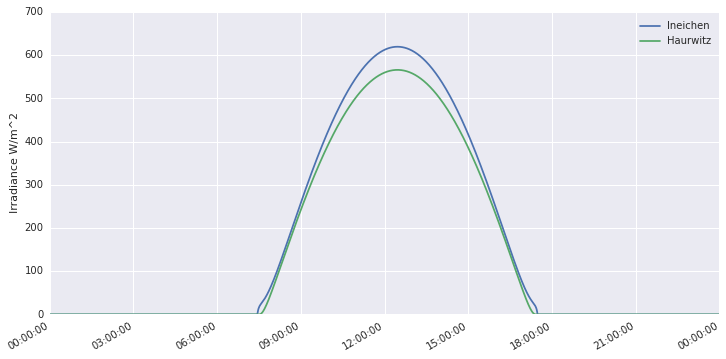

In [12]:
ineichen_data = pvlib.clearsky.ineichen(times, tus, linke_turbidity=None, zenith_data=solpos['apparent_zenith'])
haurwitz_data = pvlib.clearsky.haurwitz(solpos['apparent_zenith'])

ineichen_data['ghi'].plot(label='Ineichen')
haurwitz_data['ghi'].plot(label='Haurwitz')
plt.ylabel('Irradiance W/m^2')
plt.legend()

### Diffuse ground

The ``grounddiffuse`` function has a few different ways to obtain the diffuse light reflected from the ground given an surface tilt and the GHI.

First, you can specify the albedo of ground.

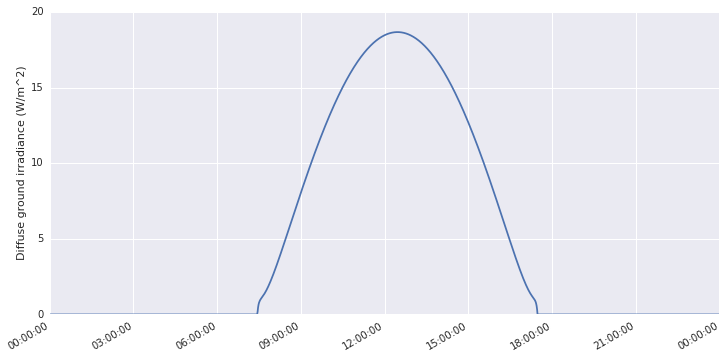

In [13]:
ground_irrad = pvlib.irradiance.grounddiffuse(40, irrad_data['ghi'], albedo=.25)
ground_irrad.plot()
plt.ylabel('Diffuse ground irradiance (W/m^2)')

Alternatively, you can specify the surface type with a string such as ``'concrete'`` or ``'snow'``. All of the available ``surface_type`` options are show in the plot below.

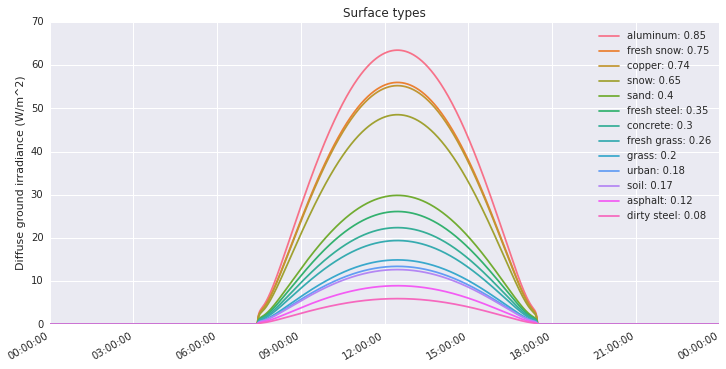

In [14]:
try:
    sns.set_palette('husl', len(pvlib.irradiance.SURFACE_ALBEDOS.items()))
except:
    pass
    
for surface, albedo in sorted(pvlib.irradiance.SURFACE_ALBEDOS.items(), key=lambda x: x[1], reverse=True):
    ground_irrad = pvlib.irradiance.grounddiffuse(40, irrad_data['ghi'], surface_type=surface)
    ground_irrad.plot(label='{}: {}'.format(surface, albedo))

plt.legend()
plt.ylabel('Diffuse ground irradiance (W/m^2)')
plt.title('Surface types')

Next, vary the tilt angle. We expect to see maximum ground diffuse irradiance at a 90 deg tilt, and no ground diffuse irradiance at 0 tilt.

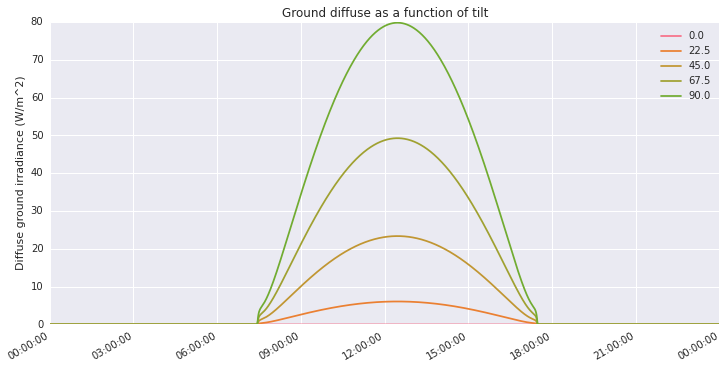

In [15]:
for surf_tilt in np.linspace(0, 90, 5):
    ground_irrad = pvlib.irradiance.grounddiffuse(surf_tilt, irrad_data['ghi'])
    ground_irrad.plot(label=surf_tilt)

plt.legend()
plt.ylabel('Diffuse ground irradiance (W/m^2)')
plt.title('Ground diffuse as a function of tilt')

In [16]:
try:
    sns.set_palette('deep')
except:
    pass

### Diffuse sky

``pvlib`` has many different ways to calculate the diffuse sky component of GHI. 

The API for some of these functions needs some work.

1. [Isotropic](#Isotropic-model)
2. [Klucher](#Klucher-model)
2. [Reindl](#Reindl-model)
2. [Hay-Davies](#Hay-Davies-model)
2. [Perez](#Perez-model)

### Isotropic model

The ``isotropic`` model is the simplest model.

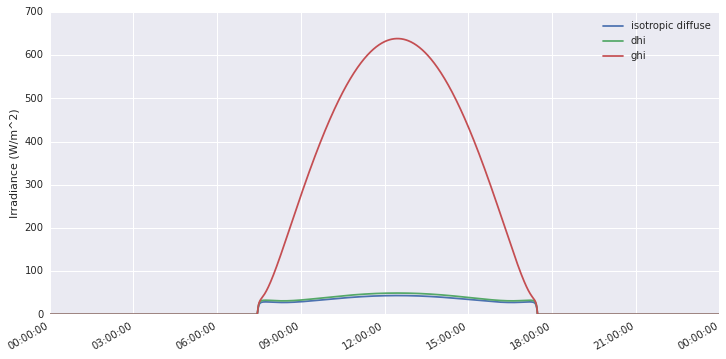

In [17]:
sky_diffuse = pvlib.irradiance.isotropic(40, irrad_data['dhi'])
sky_diffuse.plot(label='isotropic diffuse')
irrad_data['dhi'].plot()
irrad_data['ghi'].plot()
plt.legend()
plt.ylabel('Irradiance (W/m^2)')

Compare just the POA diffuse to the input DHI.

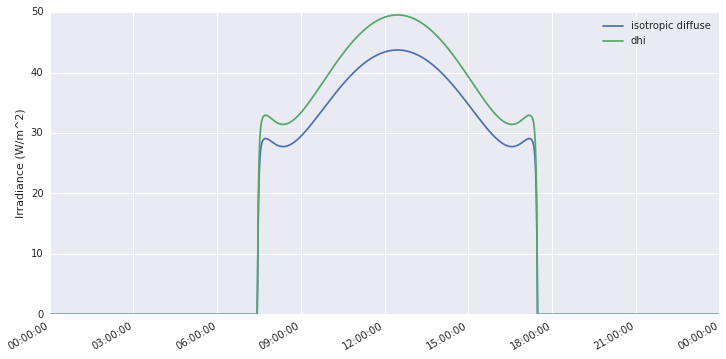

In [18]:
sky_diffuse = pvlib.irradiance.isotropic(40, irrad_data['dhi'])
sky_diffuse.plot(label='isotropic diffuse')
irrad_data['dhi'].plot()
plt.legend()
plt.ylabel('Irradiance (W/m^2)')

### Klucher model

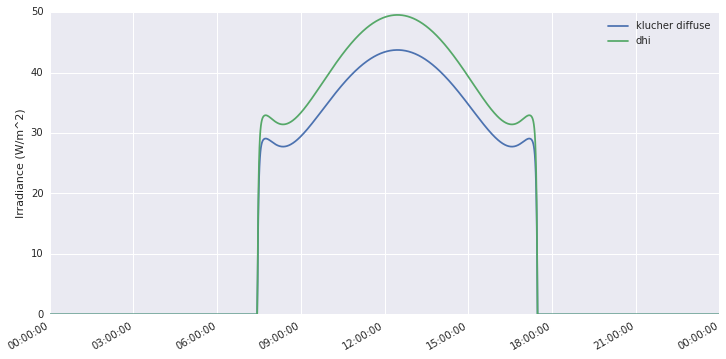

In [19]:
surf_tilt = 40
surf_az = 180

sky_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, irrad_data['dhi'], irrad_data['ghi'], 
                                       ephem_data['apparent_zenith'], ephem_data['azimuth'])
sky_diffuse.plot(label='klucher diffuse')
irrad_data['dhi'].plot()
#irrad_data['ghi'].plot()
plt.legend()
plt.ylabel('Irradiance (W/m^2)')

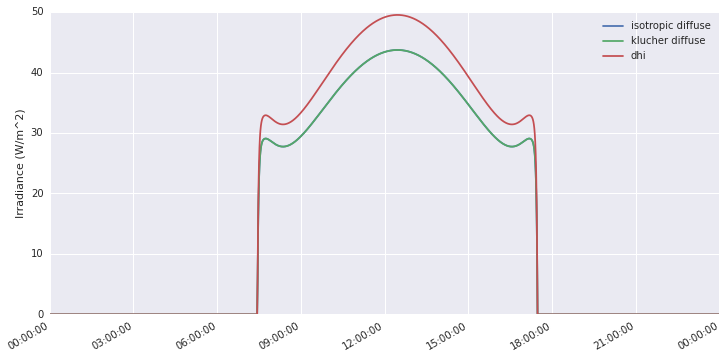

In [20]:
surf_tilt = 40
surf_az = 180 # south facing

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, irrad_data['dhi'], irrad_data['ghi'], 
                                        ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

irrad_data['dhi'].plot()

plt.legend()
plt.ylabel('Irradiance (W/m^2)')

Klucher as a function of surface azimuth.

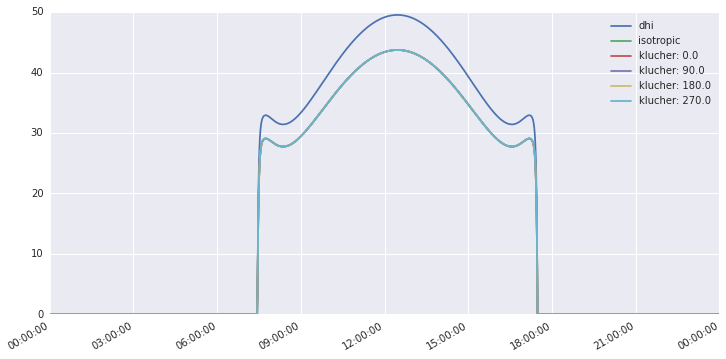

In [21]:
surf_tilt = 40

irrad_data['dhi'].plot()

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic')

for surf_az in np.linspace(0, 270, 4):
    klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
    klucher_diffuse.plot(label='klucher: {}'.format(surf_az))

plt.legend()

Surface azimuth should not matter if tilt is 0.

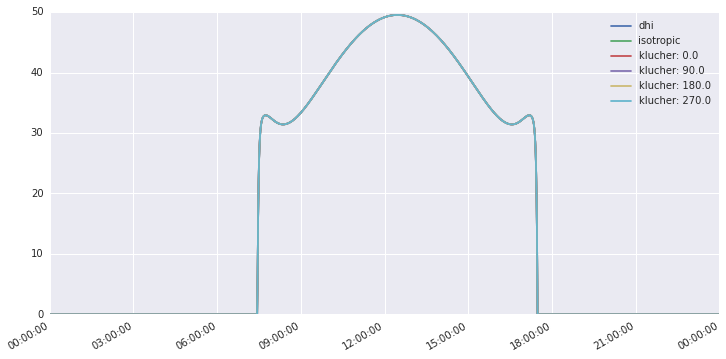

In [22]:
surf_tilt = 0

irrad_data['dhi'].plot()

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic')

for surf_az in np.linspace(0, 270, 4):
    klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, irrad_data['dhi'], irrad_data['ghi'], 
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
    klucher_diffuse.plot(label='klucher: {}'.format(surf_az))

plt.legend()

### Reindl model

South facing at latitude.

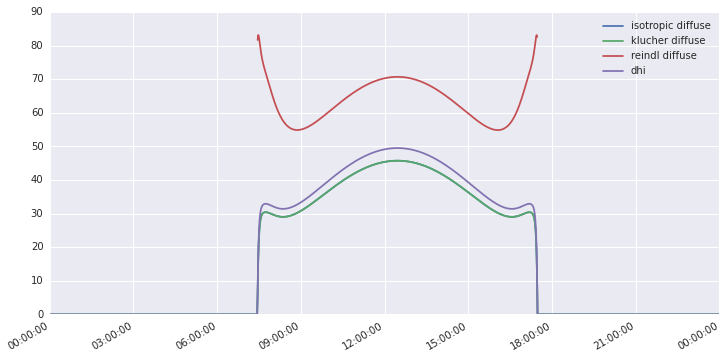

In [23]:
surf_tilt = 32
surf_az = 180 # south facing

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.extraradiation(times.dayofyear)
reindl_diffuse = pvlib.irradiance.reindl(surf_tilt, surf_az, 
                                          irrad_data['dhi'], irrad_data['dni'], irrad_data['ghi'], dni_et,
                                          ephem_data['apparent_zenith'], ephem_data['azimuth'])
reindl_diffuse.plot(label='reindl diffuse')

irrad_data['dhi'].plot()

plt.legend()

East facing

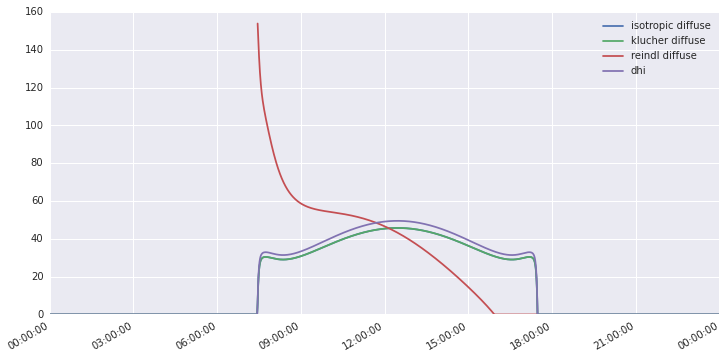

In [24]:
surf_tilt = 32
surf_az = 90 

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.extraradiation(times.dayofyear)
reindl_diffuse = pvlib.irradiance.reindl(surf_tilt, surf_az, 
                                          irrad_data['dhi'], irrad_data['dni'], irrad_data['ghi'], dni_et,
                                          ephem_data['apparent_zenith'], ephem_data['azimuth'])
reindl_diffuse.plot(label='reindl diffuse')

irrad_data['dhi'].plot()

plt.legend()

### Hay-Davies model

Hay-Davies facing south.

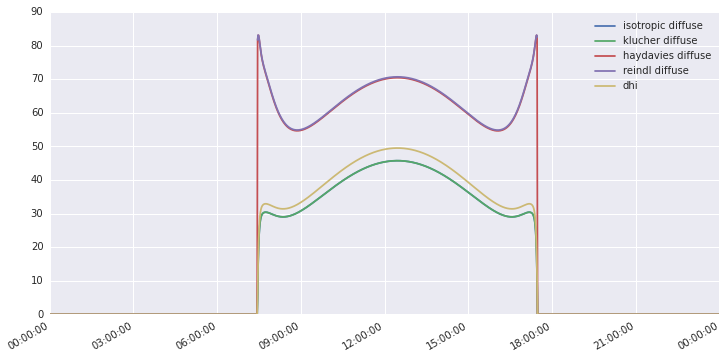

In [25]:
surf_tilt = 32
surf_az = 180 

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.extraradiation(times.dayofyear)

haydavies_diffuse = pvlib.irradiance.haydavies(surf_tilt, surf_az, 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

reindl_diffuse = pvlib.irradiance.reindl(surf_tilt, surf_az, 
                                          irrad_data['dhi'], irrad_data['dni'], irrad_data['ghi'], dni_et,
                                          ephem_data['apparent_zenith'], ephem_data['azimuth'])
reindl_diffuse.plot(label='reindl diffuse')

irrad_data['dhi'].plot()

plt.legend()

Facing east.

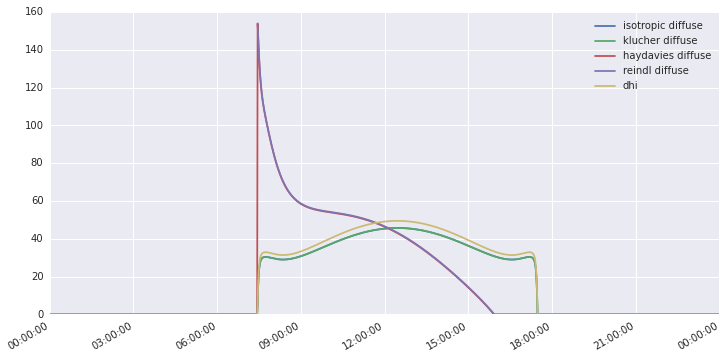

In [26]:
surf_tilt = 32
surf_az = 90 

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.extraradiation(times.dayofyear)

haydavies_diffuse = pvlib.irradiance.haydavies(surf_tilt, surf_az, 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

reindl_diffuse = pvlib.irradiance.reindl(surf_tilt, surf_az, 
                                          irrad_data['dhi'], irrad_data['dni'], irrad_data['ghi'], dni_et,
                                          ephem_data['apparent_zenith'], ephem_data['azimuth'])
reindl_diffuse.plot(label='reindl diffuse')

irrad_data['dhi'].plot()

plt.legend()

Hay-Davies appears to be very similar to Reindl. Too similar?

### King model

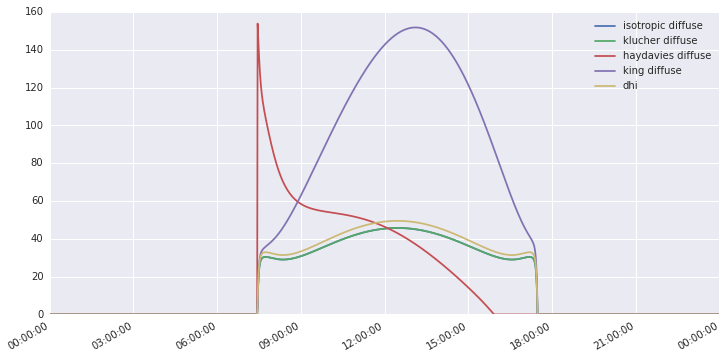

In [27]:
surf_tilt = 32
surf_az = 90 

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.extraradiation(times.dayofyear)

haydavies_diffuse = pvlib.irradiance.haydavies(surf_tilt, surf_az, 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

king_diffuse = pvlib.irradiance.king(surf_tilt,irrad_data['dhi'], irrad_data['ghi'], ephem_data['azimuth'])
king_diffuse.plot(label='king diffuse')

irrad_data['dhi'].plot()

plt.legend()

### Perez model

This section walks through the Perez algorithm.

In [28]:
sun_zen = ephem_data['apparent_zenith']
sun_az = ephem_data['azimuth']
DNI = irrad_data['dni']
DHI = irrad_data['dhi']
DNI_ET = pvlib.irradiance.extraradiation(times.dayofyear)
AM = pvlib.atmosphere.relativeairmass(sun_zen)

surf_tilt = 32
surf_az = 180

kappa = 1.041 #for sun_zen in radians
z = np.radians(sun_zen) # convert to radians

#Dhfilter = DHI > 0

# epsilon is the sky's clearness
eps = ( (DHI + DNI)/DHI + kappa*(z**3) ) / ( 1 + kappa*(z**3) )

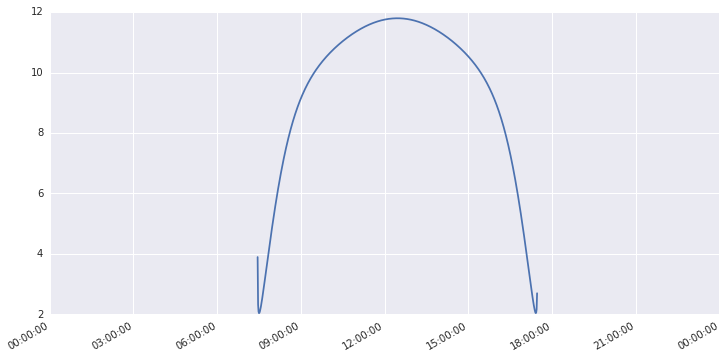

In [29]:
eps.plot()

(0, 9)

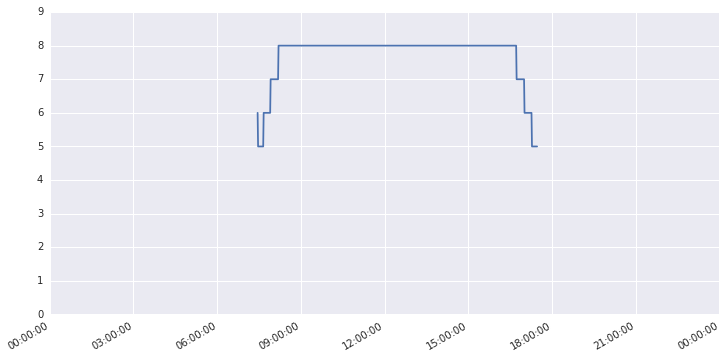

In [30]:
ebin = eps.copy()
ebin[(eps<1.065)] = 1
ebin[(eps>=1.065) & (eps<1.23)] = 2
ebin[(eps>=1.23) & (eps<1.5)] = 3
ebin[(eps>=1.5) & (eps<1.95)] = 4
ebin[(eps>=1.95) & (eps<2.8)] = 5
ebin[(eps>=2.8) & (eps<4.5)] = 6
ebin[(eps>=4.5) & (eps<6.2)] = 7
ebin[eps>=6.2] = 8

ebin.plot()
plt.ylim(0,9)

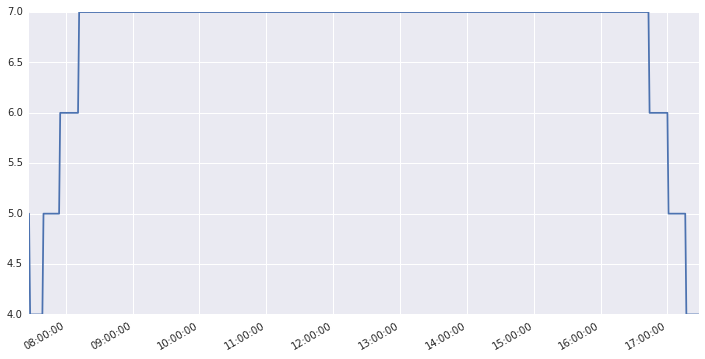

In [31]:
ebin = ebin - 1
ebin = ebin.dropna().astype(int)
ebin.plot()

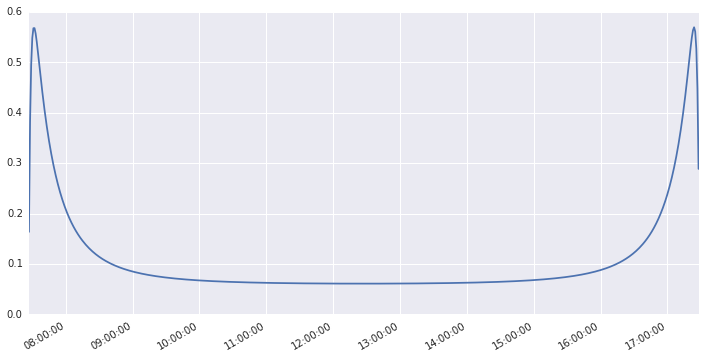

In [32]:
delta = DHI * AM / DNI_ET
delta = delta[ebin.index]
delta.plot()

In [33]:
z = z[ebin.index]

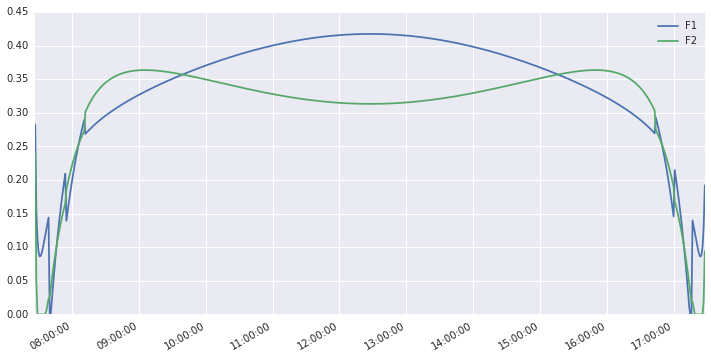

In [34]:
modelt = 'allsitescomposite1990'

F1c, F2c = pvlib.irradiance._get_perez_coefficients(modelt)

F1 = F1c[ebin,0] + F1c[ebin,1]*delta + F1c[ebin,2]*z
F1[F1<0]=0;
F1=F1.astype(float)

#F2= F2c[ebin,0] + F2c[ebin,1]*delta[ebinfilter] + F2c[ebin,2]*z[ebinfilter]
F2= F2c[ebin,0] + F2c[ebin,1]*delta + F2c[ebin,2]*z
F2[F2<0]=0
F2=F2.astype(float)

F1.plot(label='F1')
F2.plot(label='F2')
plt.legend()

In [35]:
from pvlib import tools

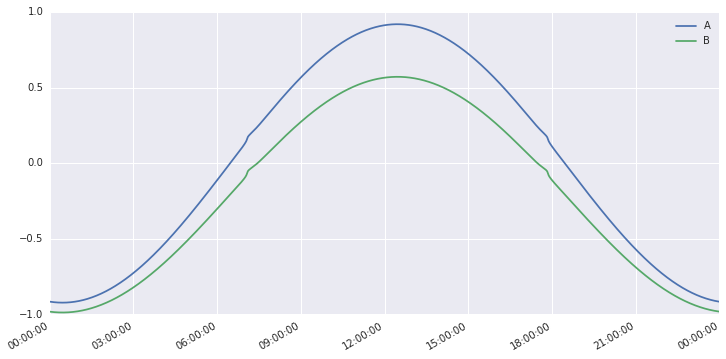

In [36]:
A = tools.cosd(surf_tilt)*tools.cosd(sun_zen) + tools.sind(surf_tilt)*tools.sind(sun_zen)*tools.cosd(sun_az-surf_az) #removed +180 from azimuth modifier: Rob Andrews October 19th 2012
#A[A < 0] = 0

B = tools.cosd(sun_zen);
#B[B < pvl_tools.cosd(85)] = pvl_tools.cosd(85)

A.plot(label='A')
B.plot(label='B')
plt.legend()

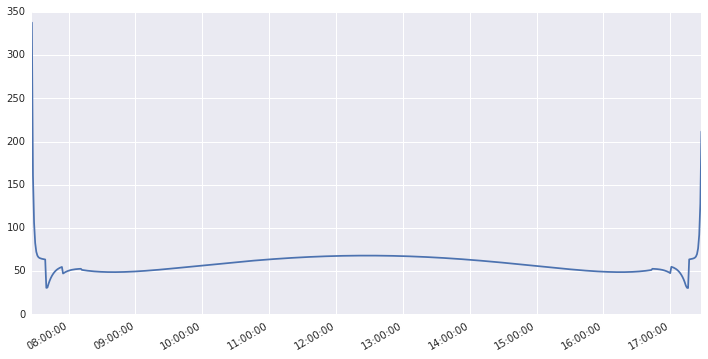

In [37]:
sky_diffuse = DHI[ebin.index]*( 0.5* (1-F1)*(1+tools.cosd(surf_tilt))+F1 * A[ebin.index]/ B[ebin.index] + F2*tools.sind(surf_tilt))
sky_diffuse[sky_diffuse < 0] = 0

sky_diffuse.plot()

Compare the Perez model to others.

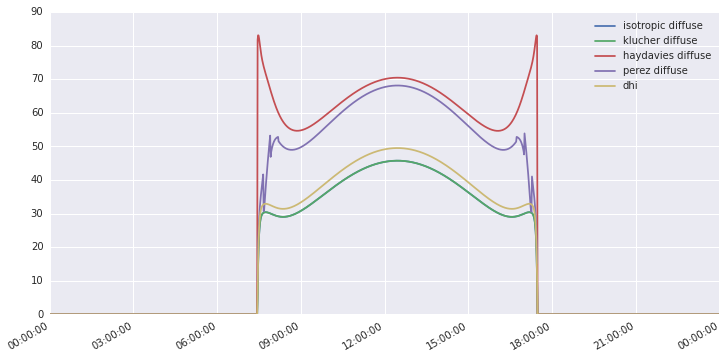

In [38]:
sun_zen = ephem_data['apparent_zenith']
sun_az = ephem_data['azimuth']
DNI = irrad_data['dni']
DHI = irrad_data['dhi']
DNI_ET = pvlib.irradiance.extraradiation(times.dayofyear)
AM = pvlib.atmosphere.relativeairmass(sun_zen)

surf_tilt = 32
surf_az = 180

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.extraradiation(times.dayofyear)

haydavies_diffuse = pvlib.irradiance.haydavies(surf_tilt, surf_az, 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

perez_diffuse = pvlib.irradiance.perez(surf_tilt, surf_az, 
                                        irrad_data['dhi'], irrad_data['dni'], dni_et,
                                        ephem_data['apparent_zenith'], ephem_data['azimuth'],
                                        AM)
perez_diffuse.plot(label='perez diffuse')

irrad_data['dhi'].plot()

plt.legend()

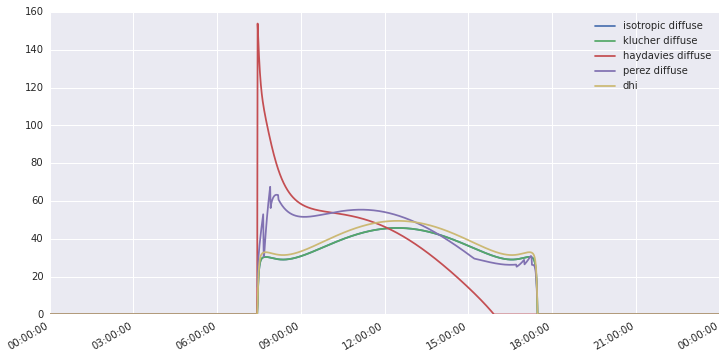

In [39]:
sun_zen = ephem_data['apparent_zenith']
sun_az = ephem_data['azimuth']
DNI = irrad_data['dni']
DHI = irrad_data['dhi']
DNI_ET = pvlib.irradiance.extraradiation(times.dayofyear)
AM = pvlib.atmosphere.relativeairmass(sun_zen)

surf_tilt = 32
surf_az = 90

iso_diffuse = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
iso_diffuse.plot(label='isotropic diffuse')

klucher_diffuse = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
klucher_diffuse.plot(label='klucher diffuse')

dni_et = pvlib.irradiance.extraradiation(times.dayofyear)

haydavies_diffuse = pvlib.irradiance.haydavies(surf_tilt, surf_az, 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

perez_diffuse = pvlib.irradiance.perez(surf_tilt, surf_az, 
                                        irrad_data['dhi'], irrad_data['dni'], dni_et,
                                        ephem_data['apparent_zenith'], ephem_data['azimuth'],
                                        AM)
perez_diffuse.plot(label='perez diffuse')

irrad_data['dhi'].plot()

plt.legend()

Examine the impact of the coeffecient selection.

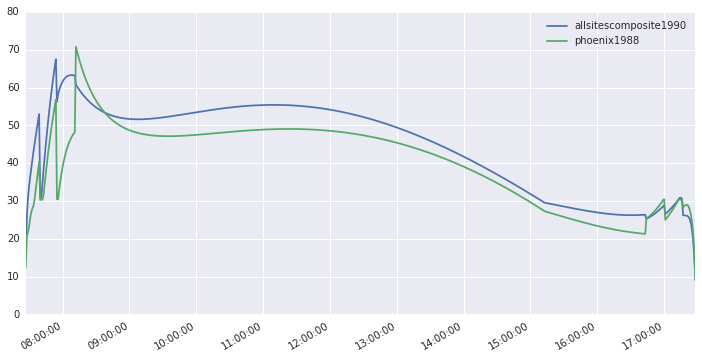

In [40]:
perez_diffuse = pvlib.irradiance.perez(surf_tilt, surf_az, 
                                        irrad_data['dhi'], irrad_data['dni'], dni_et,
                                        ephem_data['apparent_zenith'], ephem_data['azimuth'],
                                        AM, modelt='allsitescomposite1990')
perez_diffuse.plot(label='allsitescomposite1990')

perez_diffuse = pvlib.irradiance.perez(surf_tilt, surf_az, 
                                        irrad_data['dhi'], irrad_data['dni'], dni_et,
                                        ephem_data['apparent_zenith'], ephem_data['azimuth'],
                                        AM, modelt='phoenix1988')
perez_diffuse.plot(label='phoenix1988')

plt.legend()

## Angle of incidence functions

The ``irradiance`` module has some convenience functions to help calculate the angle of incidence.

First, the angle of incidence.

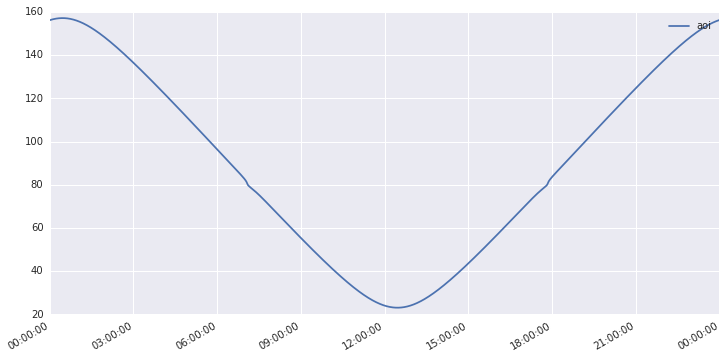

In [41]:
proj = pvlib.irradiance.aoi(32, 180, ephem_data['apparent_zenith'], ephem_data['azimuth'])
proj.plot()

#plt.ylim(-1.1,1.1)
plt.legend()

AOI projection: the dot production of the surface normal and the vector to the sun.

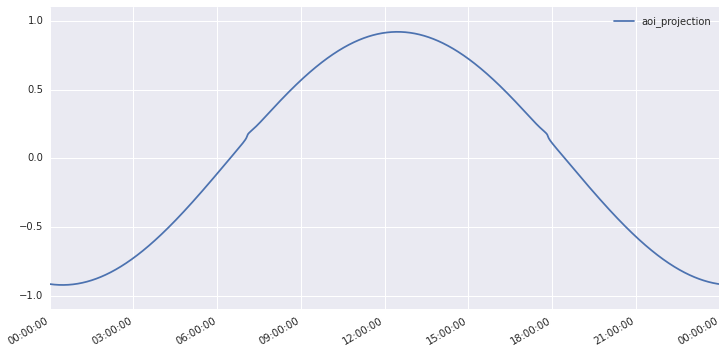

In [42]:
proj = pvlib.irradiance.aoi_projection(32, 180, ephem_data['apparent_zenith'], ephem_data['azimuth'])
proj.plot()

plt.ylim(-1.1,1.1)
plt.legend()

The ratio between POA projection and the horizontal projection.

(-4, 4)

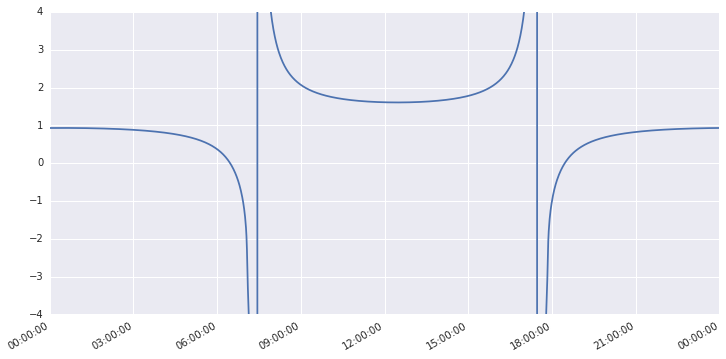

In [43]:
ratio = pvlib.irradiance.poa_horizontal_ratio(32, 180, ephem_data['apparent_zenith'], ephem_data['azimuth'])
ratio.plot()
plt.ylim(-4,4)

This plot shows that an explicit dot product calculation gives the same result as ``aoi_projection``.

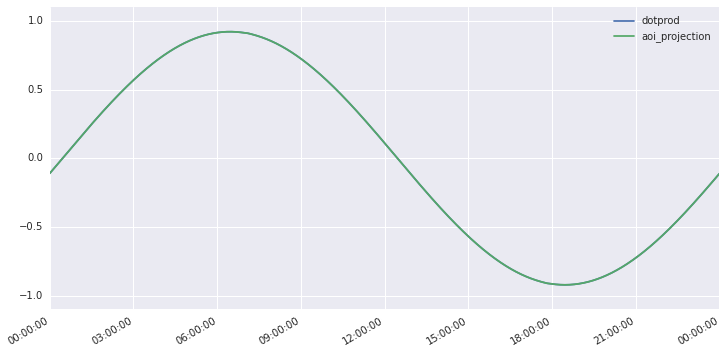

In [44]:
surf_tilt = 90
surf_az = 90

sen_alt_rad = np.radians(90 - surf_tilt)
sen_azi_rad = np.radians(surf_az)

alts = np.radians(90 - ephem_data['apparent_zenith'])
azis = np.radians(ephem_data['apparent_azimuth'])

dotprod = np.cos(sen_alt_rad)*np.cos(alts)*np.cos(sen_azi_rad-azis) + np.sin(sen_alt_rad)*np.sin(alts)
dotprod.plot(label='dotprod')

proj = pvlib.irradiance.aoi_projection(surf_tilt, surf_az, ephem_data['apparent_zenith'], ephem_data['azimuth'])
proj.plot()

plt.ylim(-1.1,1.1)
plt.legend()

### total_irrad

There is an experimental convenience function ``total_irrad`` that aims to make it easier to play with different models. For now, we use it to make summary plots of the models explored above.

South facing with latitude tilt.

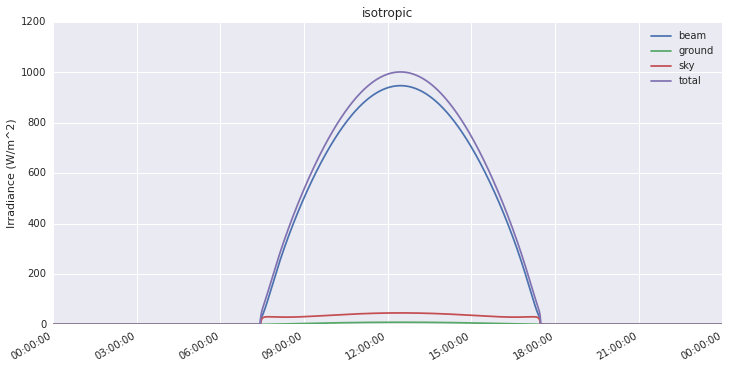

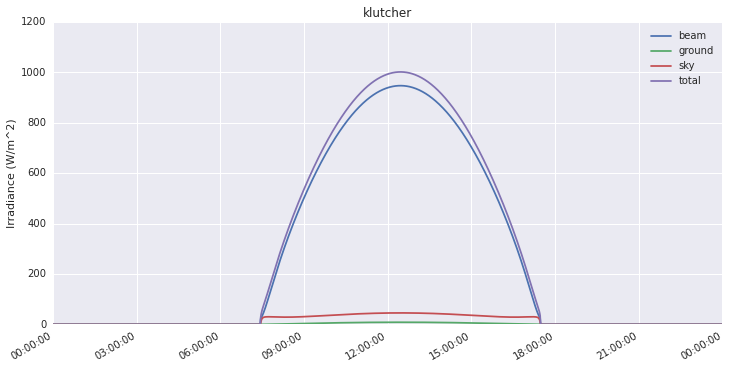

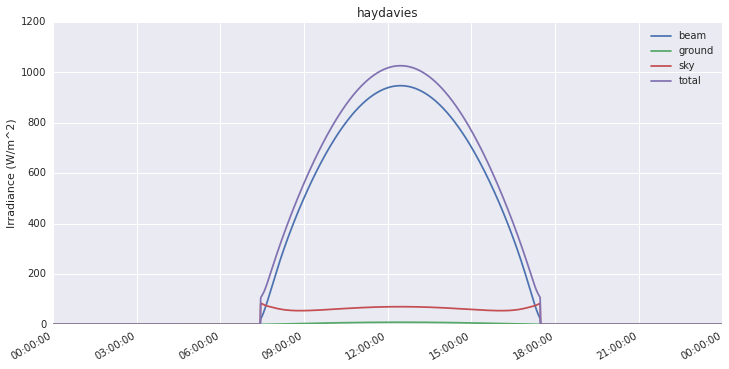

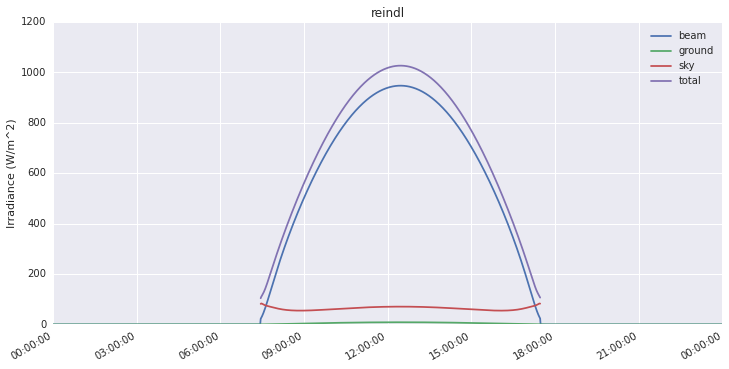

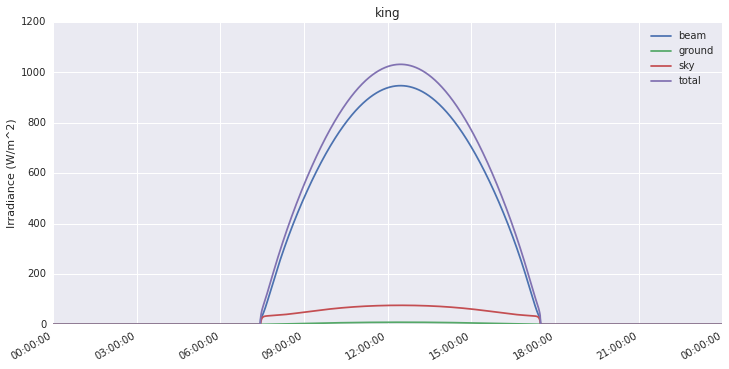

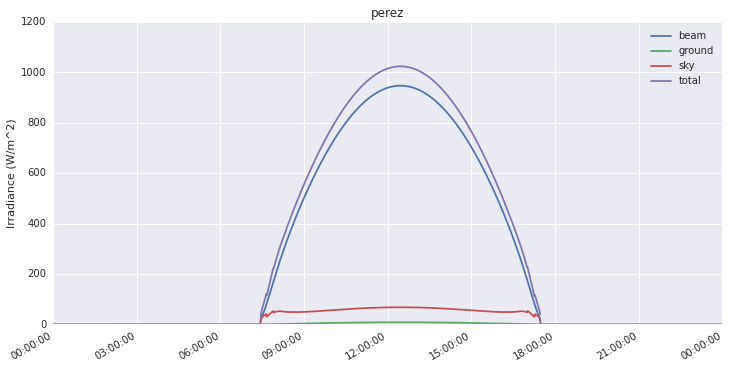

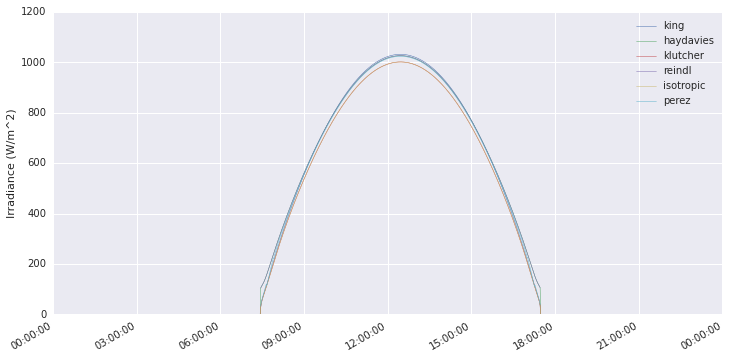

In [45]:
models = ['isotropic', 'klutcher', 'haydavies', 'reindl', 'king', 'perez']
totals = {}

for model in models:
    total = pvlib.irradiance.total_irrad(32, 180, 
                                           ephem_data['apparent_zenith'], ephem_data['azimuth'],
                                           dni=irrad_data['dni'], ghi=irrad_data['ghi'], dhi=irrad_data['dhi'],
                                           dni_extra=dni_et, airmass=AM,
                                           model=model,
                                           surface_type='urban')
    totals[model] = total
    total.plot()
    plt.title(model)
    plt.ylabel('Irradiance (W/m^2)')
    
    
plt.figure()
for model, total in totals.items():
    total['total'].plot(lw=.5, label=model)
    
plt.legend()
plt.ylabel('Irradiance (W/m^2)')

tilt = 0

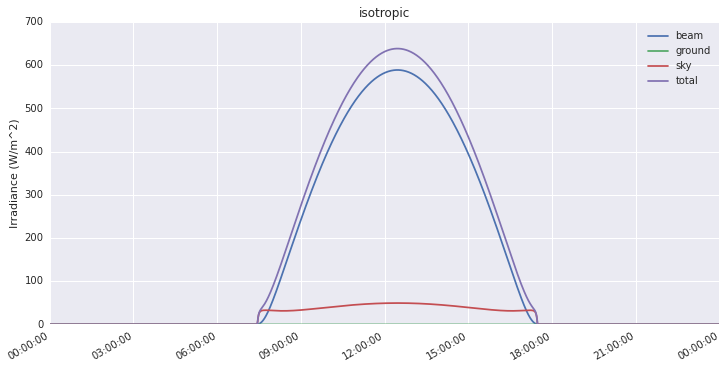

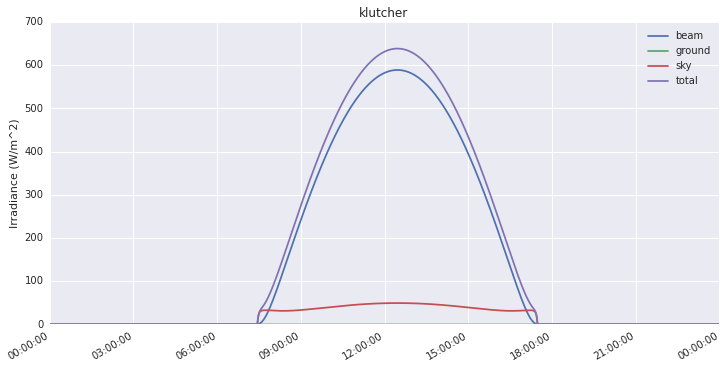

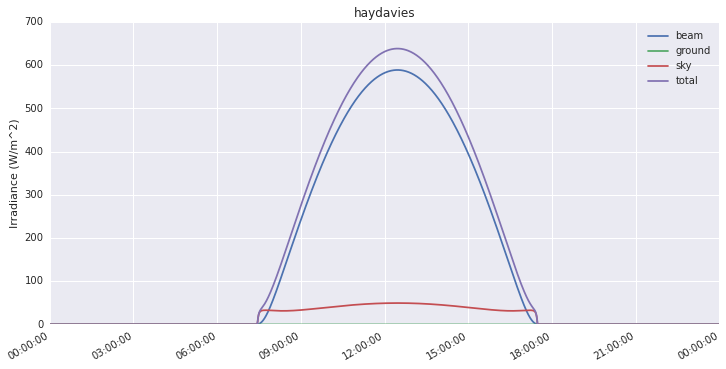

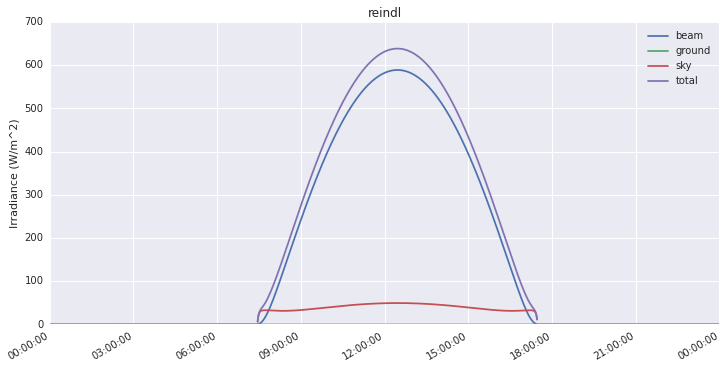

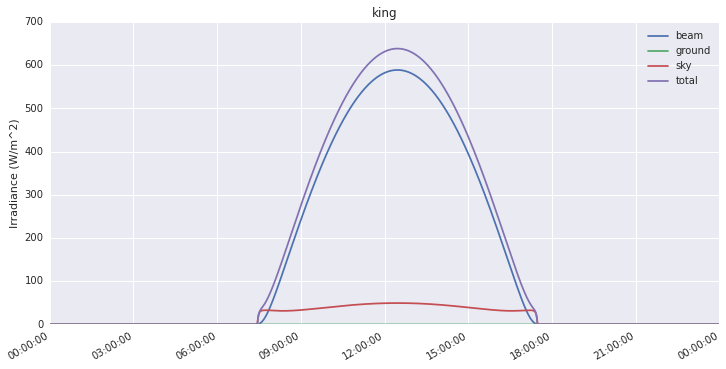

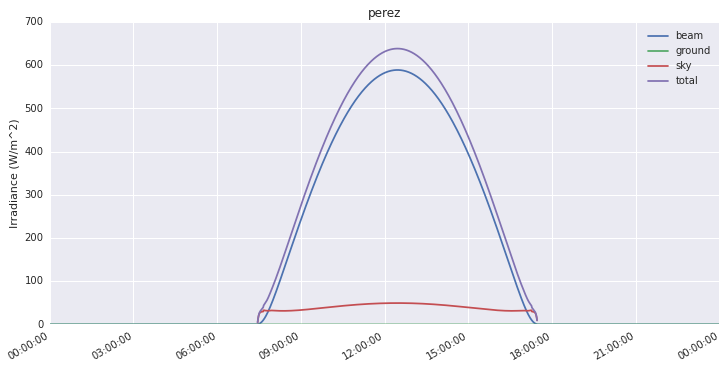

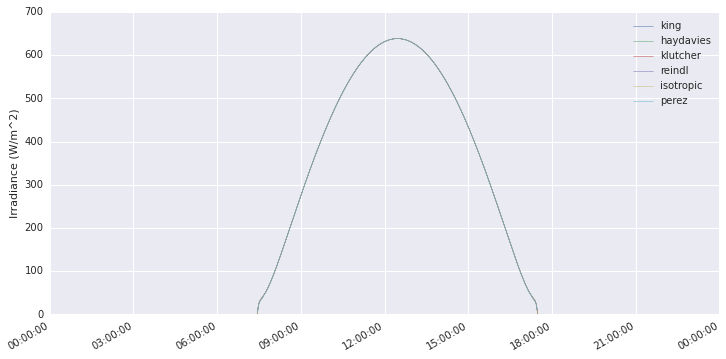

In [46]:
models = ['isotropic', 'klutcher', 'haydavies', 'reindl', 'king', 'perez']
totals = {}

for model in models:
    total = pvlib.irradiance.total_irrad(0, 180, 
                                           ephem_data['apparent_zenith'], ephem_data['azimuth'],
                                           dni=irrad_data['dni'], ghi=irrad_data['ghi'], dhi=irrad_data['dhi'],
                                           dni_extra=dni_et, airmass=AM,
                                           model=model,
                                           surface_type='urban')
    totals[model] = total
    total.plot()
    plt.title(model)
    plt.ylabel('Irradiance (W/m^2)')
    
    
plt.figure()
for model, total in totals.items():
    total['total'].plot(lw=.5, label=model)
    
plt.legend()
plt.ylabel('Irradiance (W/m^2)')

East facing with latitude tilt.

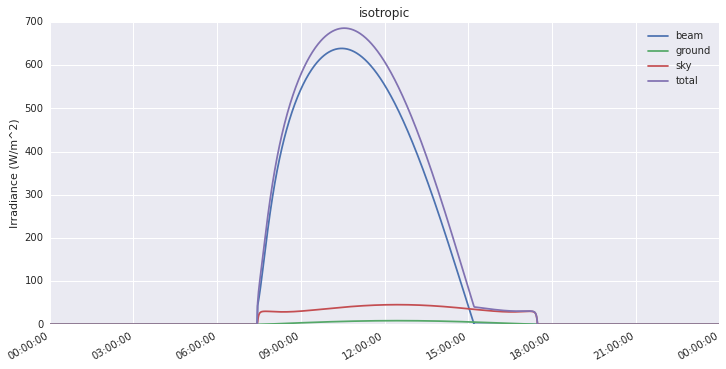

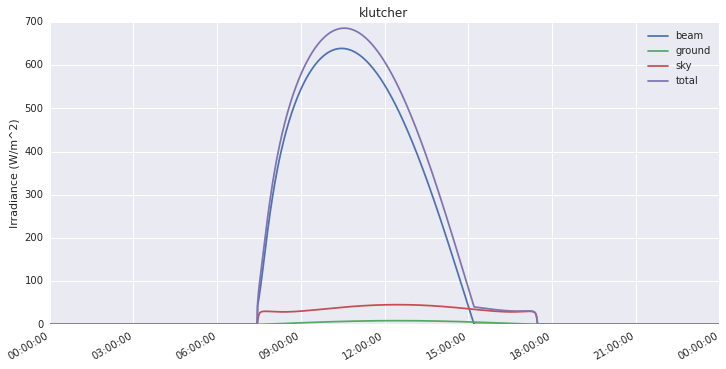

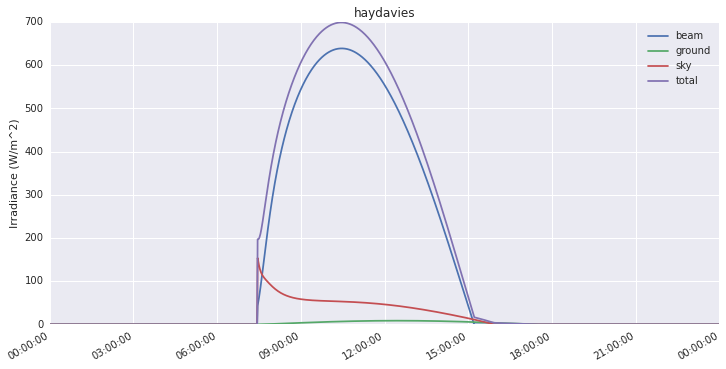

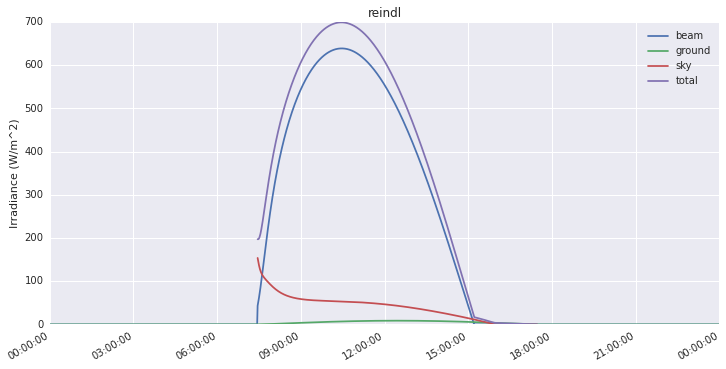

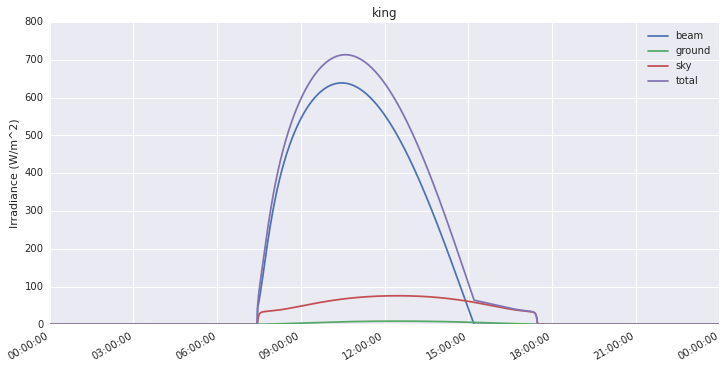

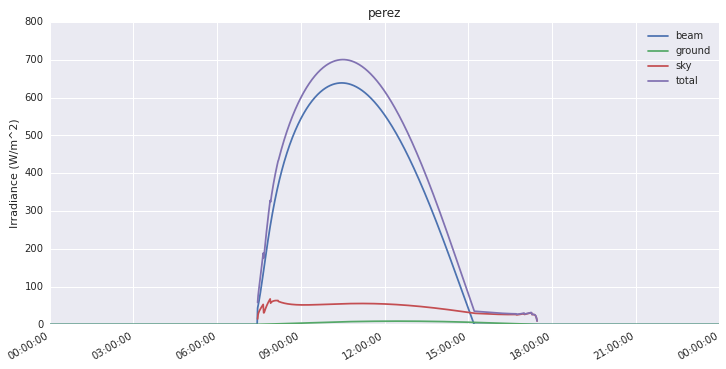

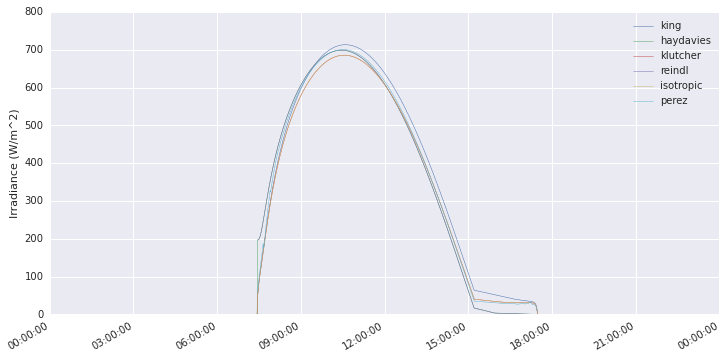

In [47]:
models = ['isotropic', 'klutcher', 'haydavies', 'reindl', 'king', 'perez']
totals = {}

for model in models:
    total = pvlib.irradiance.total_irrad(32, 90, 
                                           ephem_data['apparent_zenith'], ephem_data['azimuth'],
                                           dni=irrad_data['dni'], ghi=irrad_data['ghi'], dhi=irrad_data['dhi'],
                                           dni_extra=dni_et, airmass=AM,
                                           model=model,
                                           surface_type='urban')
    totals[model] = total
    total.plot()
    plt.title(model)
    plt.ylabel('Irradiance (W/m^2)')
    
    
plt.figure()
for model, total in totals.items():
    total['total'].plot(lw=.5, label=model)
    
plt.legend()
plt.ylabel('Irradiance (W/m^2)')